# Лабораторная работа Авторегрессия и LSTM

## Задание



Необходимо сгенерировать синтетические данные и обучить на них модель авторегрессии, модель LSTM.

Обучить рекуррентную нейронную сеть на реальных данных погоды по варианту.

Отчет должен содержать: титульный лист, задание с вариантом, скриншоты и краткие пояснения по каждому этапу лабораторной работы. Результаты моделей авторегрессии, LSTM на систетических данных, а также результаты обучения на реальных данных, итоговую таблицу со результатами для всех вариантов обучения

Вариант города соответствует группе: 1 - Москва, 2 - Санкт-Петербург, 3 - Новосибирск, 4 - Екатеринбург

## Задания для самостоятельной работы
1. Проведите обучение трех моделей по вашему варианту для вашего города.
2. Измените гиперпараметры обучения для улучшения модели: количество эпох, размер батча, скорость обучения
3. Создайте два варианта синтетических данных: первый вариант только сезонная компонента и шум; второй вариант только меняющийся тренд и шум
4. Измените конфигурацию нейросети: оставьте одну однонаправленную ячейку LSTM с выходным полносвязным слоем. Обучите ее на новых синтетических данных и сравните 3 разных варианта размерности состояния ячейки.
5. Укажите, какие действия помогли улучшить метрики ваших моделей и объясните почему.
6. Укажите в отчете как меняется количество обучаемых в LSTM параметров при изменении ее конфигурации

## Контрольные вопросы
1. Что такое временной ряд
2. Формула авторегрессии
3. Что такое рекуррентная нейронная сеть?
4. Отличия LSTM и GRU
5. Что такое вентиль? Какие вентили есть в LSTM?
6. Размерность входных, выходных данных и состояния для LSTM
7. Что такое двунаправленная LSTM?
8. Модель seq2seq
9. Генерация текста с помощью RNN

## Импорт библиотек

In [2]:
# !pip install torchsummary
# !pip install gdown

import time
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

from datetime import datetime
import os

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [294]:
!nvidia-smi

Mon May 13 13:51:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              31W / 250W |   5732MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Часть 1 (Синтетические данные)

### Создание ряда df

По идее,
- `np.sin(X/50)` - это детерминированная составляющая (исходные данные);
- `-np.sin(X/200)` - это сезонная компонента;
- `(2*X/X.size)**2` - это меняющийся тренд;
- `np.random.normal(scale=0.25, size=y.size)` - это шум.

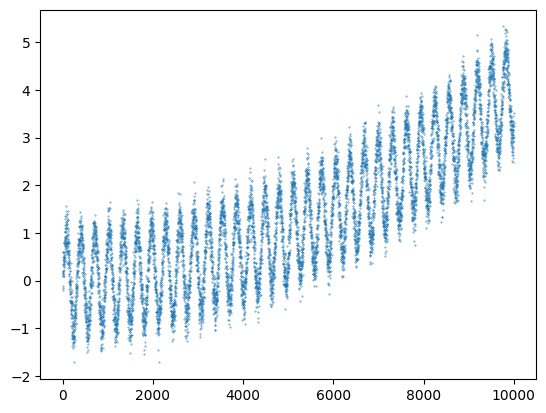

In [4]:
X = np.arange(10000)
y = np.sin(X/50)-np.sin(X/200)+(2*X/X.size)**2 # Исходный: и сезонная компонента, и меняющийся тренд
# y = np.sin(X/50)-np.sin(X/200) # сезонная компонента
# y = np.sin(X/50)+(2*X/X.size)**2 # меняющийся тренд

y += np.random.normal(scale=0.25, size=y.size)
plt.scatter(X, y[:10000], s=0.1)

df = pd.Series(y)

### Демонстрация подготовки датасета
Это просто демонстрация. Далее по коду WINDOW_SIZE, X, Y будут меняться, а выборка будет создаваться заново на основе значений в df по этому же алгоритму.

In [5]:
X = []
WINDOW_SIZE = 200

# # Упрошенный пример для понимания принципа создания датасета в этой лабе
# df = pd.Series([1,2,4,5,7,8,10,11,13,14])
# X = []
# WINDOW_SIZE = 3

def getWindows(x):
    X.append(x.values.copy())
    return 0

# Rolling (например, year) - Скользящий период на графике
df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
X = np.array(X)
print(X.shape)

y = X[:, WINDOW_SIZE:].copy()
X = X[:, :WINDOW_SIZE].copy()
print(X.shape, y.shape)

# Демонстрация скользящего окна.
# 5 первых значений "окна" с индексом 0 и 5 первых значений "окна" с индексом 1
X[:5, 0], X[:5, 1]

(9800, 201)
(9800, 200) (9800, 1)


(array([ 0.18669295, -0.10672442, -0.20583321,  0.09747123,  0.32162956]),
 array([-0.10672442, -0.20583321,  0.09747123,  0.32162956,  0.14610582]))

(8820, 199) (8820, 1)


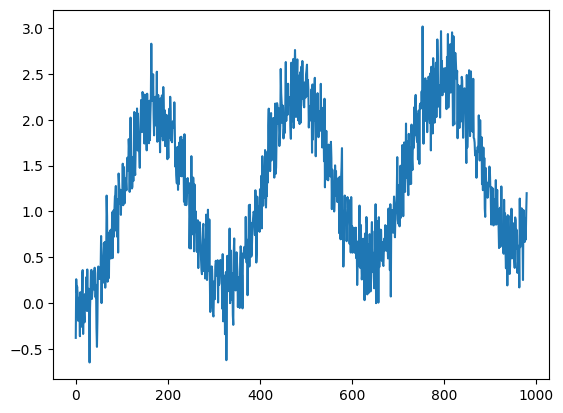

In [6]:
X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()
# Датасетом являются приращения дельта_t (см. np.diff)
# y - это разница между реальным y и последним в последовательности X длины WINDOW_SIZE x_(n-1)
# x_t заменяется delta_x_t на его разницу с предыдущим x_(t-1): delta_x_t = x_t - x_(t-1)
y_train -= X_train[:, -1:]
X_train = np.diff(X_train)
print(X_train.shape, y_train.shape)

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()
y_test -= X_test[:, -1:]
X_test = np.diff(X_test)

# Исходную функцию после np.diff можно восстановить с помощью np.cumsum
plt.plot(np.cumsum(y_test))

По задумке Канева (так он сказал в "мастер классе") тут мы должны наблюдать, как одни и те же части датасета в двух соседних циклах накладываютя друг на друга. И типа 2 соседних сезонных цикла могут чуть-чуть не совпадать.

На деле по коду мы видим другое - сдвиг в скользящем окне:
- lag1 - последние значения $x_t$ в ста последних окнах
- lag0 - соответствующие этим стам окнам сто значений игрек

Графики полностью совпадают. Сдвиг одного относительно другого - 1 - это шаг скользящего окна.

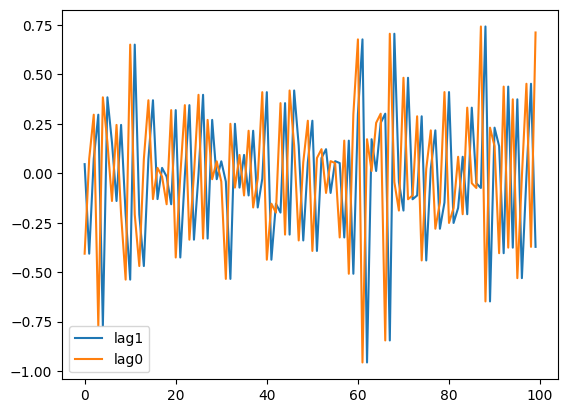

In [299]:
plt.plot(X_test[-100:,-1], label='lag1')
plt.plot(y_test[-100:], label='lag0')
plt.legend()

## Часть 2 (Реальные данные)

### Загрузка данных

In [16]:
# По варианту
# Перейдите по ссылке https://drive.google.com/drive/folders/1FtEVU702DjlTjoecxbbNBl5nP9SCu7Rw

# FILE_NAME = "climate_moscow.csv"
FILE_NAME = "climate_piter.csv"

!gdown --folder https://drive.google.com/drive/folders/1FtEVU702DjlTjoecxbbNBl5nP9SCu7Rw

Retrieving folder contents
Processing file 1mBIyf4Zo4ChrQ0R6EvwdrkQzrAKpX27c climate_ekb.csv
Processing file 1B0RgTX4TN8WuLkXins8D1pnrdhntHPXQ climate_moscow.csv
Processing file 18AVqfU6mtCwuqkuC6feZs9slE-WJk9MU climate_novosib.csv
Processing file 12SudJ27Zzxrd2eg4wsMDrfDQMTkacuFL climate_piter.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1mBIyf4Zo4ChrQ0R6EvwdrkQzrAKpX27c
To: /kaggle/working/climate/climate_ekb.csv
100%|███████████████████████████████████████| 3.75M/3.75M [00:00<00:00, 232MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B0RgTX4TN8WuLkXins8D1pnrdhntHPXQ
To: /kaggle/working/climate/climate_moscow.csv
100%|███████████████████████████████████████| 3.70M/3.70M [00:00<00:00, 206MB/s]
Downloading...
From: https://drive.google.com/uc?id=18AVqfU6mtCwuqkuC6feZs9slE-WJk9MU
To: /kaggle/working/climate/climate_novosib.csv
100%|███████████████████████████████

### Создание ряда df_real

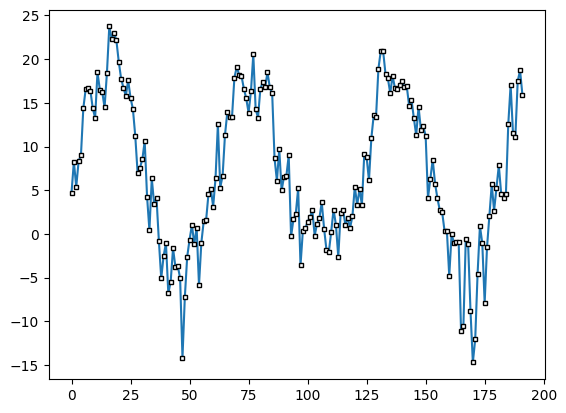

In [17]:
# По варианту проделать те же шаги для набора данных с погодой за полвека
df_real = pd.read_csv('climate/' + FILE_NAME, sep='\t')
df_real = df_real[df_real.year>1972].copy()
df_real['quartile'] = df_real.day//7

plt.plot(
    df_real.groupby(['year', 'month', 'quartile'])
      .Temperature
      .aggregate('mean')
      .iloc[-4*12*4:]
      .reset_index()
      .Temperature,
   #rot=90,
   #ylabel='temperature',
   marker='s',
   markersize=3,
   markerfacecolor='white',
   markeredgecolor='k'
)

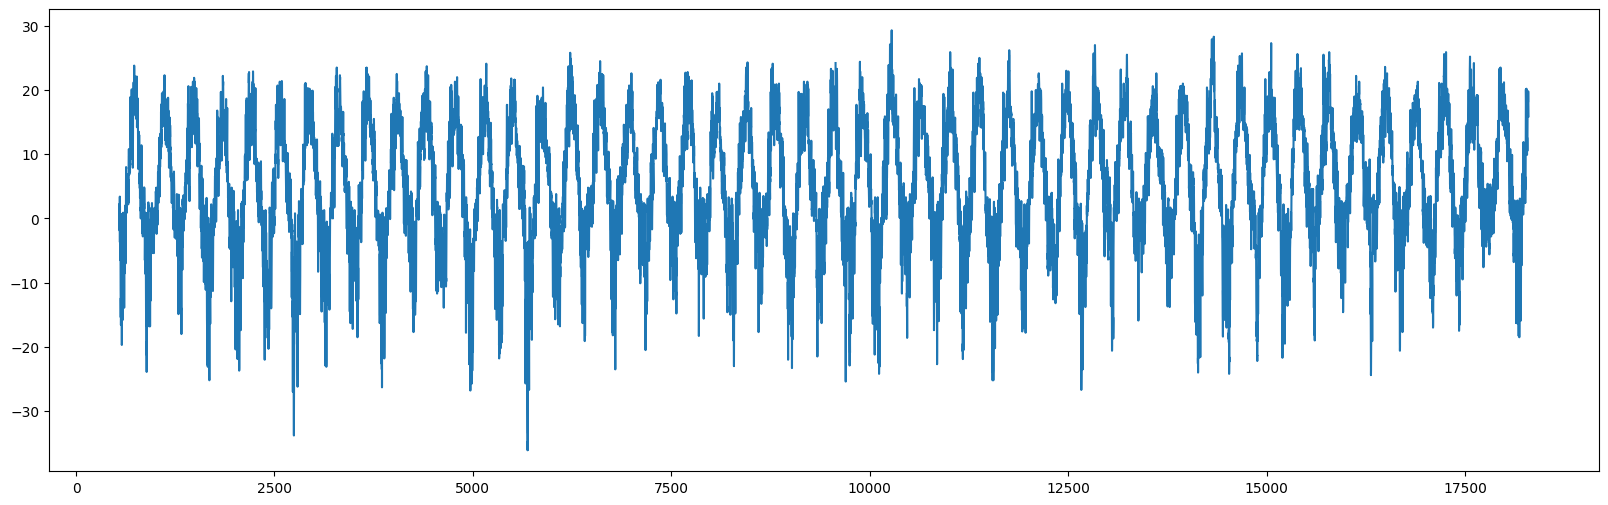

In [18]:
plt.figure(figsize=(20,6))
plt.plot(df_real.Temperature)

In [20]:
# Число записей по каждому году
print([df_real[df_real['year'] == i]['year'].count() for i in range(1973, 2022)])

[366, 367, 366, 368, 366, 367, 366, 368, 366, 367, 366, 368, 365, 366, 367, 367, 367, 366, 367, 367, 367, 366, 367, 367, 367, 366, 367, 367, 366, 367, 366, 368, 366, 367, 366, 368, 366, 366, 366, 366, 365, 366, 365, 366, 365, 365, 365, 366, 165]


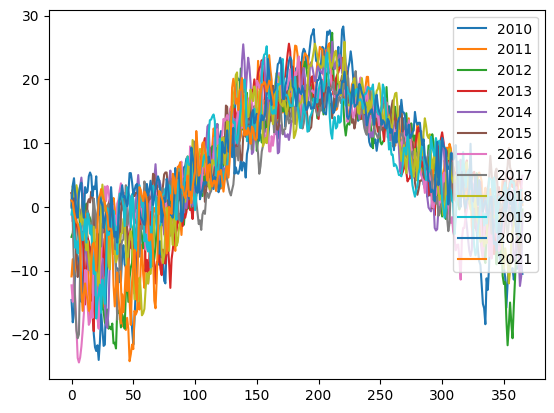

In [21]:
# Значения по дням для 2010-2021 годов.
# Зимой (1 января) должно быть сильно ниже нуля. Летом - +20-30.
# От года к году графики должны накладываться друг на друга. Это сезонность.
for i in range(2010, 2021 + 1):
  this_year_data = df_real[df_real['year'] == i]
  plt.plot(np.arange(0, len(this_year_data)), this_year_data['Temperature'], label = i)
plt.legend(loc=1)

In [306]:
# Проверка что данные отсортированы по датам. Они отсортированы.
# df_real = df_real.sort_values(['year', 'month', 'day'], ascending=[True, True, True]).reset_index()
# plt.figure(figsize=(20,6))
# plt.plot(df_real.Temperature)

In [22]:
df_real = df_real.Temperature.diff().dropna()
df_real.shape

(17746,)

In [308]:
# вот те же данные - дни с 2010 года (примерно)
# plt.plot(np.cumsum(df_real[365*(2010-1973):]))

## Модель авторегрессии (AR)

На синтетических данных.

Обучается очень быстро на всех окнах сразу. Даже на CPU. Для этого пункта GPU не нужна, строчек `.to(device)` нет. В отличие от LSTM.

In [25]:
# Функция подсчета качества модели для ВР с помощью R2 score
def time_series_score(y_true, y_pred, X_true, previous_cnt=1):
    true_values = y_true
    pred_values = y_pred

    last_value = X_true[:,-previous_cnt:].mean(axis=-1)
    variance_dummy = ((last_value - true_values)**2).mean()
    variance_pred = ((pred_values - true_values)**2).mean()
    #print(variance_dummy, variance_pred)
    # 1 - (дисперсия ошибки модели y|X / дисперсия случайной величины y)
    r2 = 1 - variance_pred/variance_dummy
    #r2_adj = 1 - (1-r2)*(y_true.size - 1)/(y_true.size - X_true.shape[1] - 1)
    return r2

def recursive_predict(model, X):
    preds = []
    length = X.shape[0]
    last_vals = X[0].copy()
    for i in range(length):
        preds.append(model.predict([last_vals]))
        # Во такой вот сдвиг. на место последнего затем встанет только что предсказанное preds[-1]
        # a = [1,2,3,4,5,6]
        # a[:-1] = a[1:]
        # a # out [2, 3, 4, 5, 6, 6]
        last_vals[:-1] = last_vals[1:]
        last_vals[-1:] = preds[-1]
    return np.array(preds).reshape(-1)

### Определение оптимального размера окна

Обучаем 1 модель LinearRegression и делаем 2 прогноза: прогноз на 1 шаг и рекуррентный прогноз.

Эта демонстрация показывает,что чем больше размер окна, тем точнее модель прогнозирует ряд. Можно было сразу обучить модель на окне размером 977. Но не всегда. Надо смотреть по MAE.

Каждый шаг увеличиваем размер окна от 2 до 1001 на 25: ```[  2,  27,  52,  77, 102, 127, 152, 177, 202, 227, 252, 277, 302,
       327, 352, 377, 402, 427, 452, 477, 502, 527, 552, 577, 602, 627,
       652, 677, 702, 727, 752, 777, 802, 827, 852, 877, 902, 927, 952,
       977]```
Сначала скармливаем 25 значений синтетической выборки `df`. Потом 50, 75 и т.п.

Эти значения бьются в отношении 9:1. **На них обучается LinearRegression**. Для обученной модели делается 2 предсказания - на следующий 1 шаг (прогноз на 1 шаг) и рекурсивное на <длина X> шагов (рекуррентный прогноз). Для обоих предсказаний расчитываются ошибки MAE, R2 score, TSS.

`stats` - это массив 6 x <Число эпох>. Сначала пишется тройка MAE, R2 score, TSS для прогноза на 1 шаг, затем - тройка MAE, R2 score, TSS для рекуррентного прогноза.

`series` - это массив 2 x <Число эпох>. Сначала пишется результат предсказания на 1 шаг, затем - для рекуррентного прогноза.

Каждые 10 эпох график обновляется.

  0%|          | 0/40 [00:00<?, ?it/s]

(17519, 227) (17519, 1)


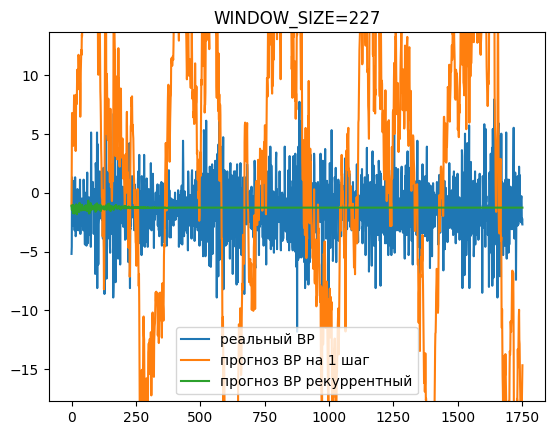

(17269, 477) (17269, 1)


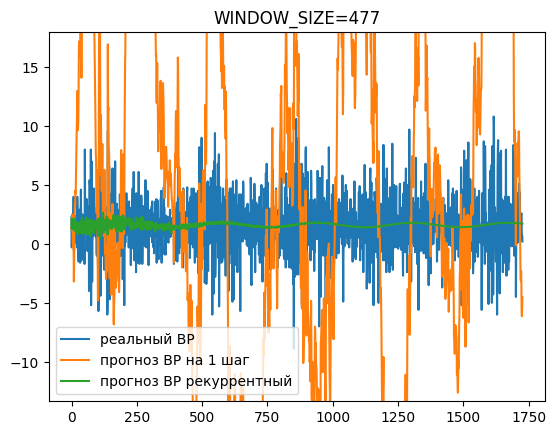

(17019, 727) (17019, 1)


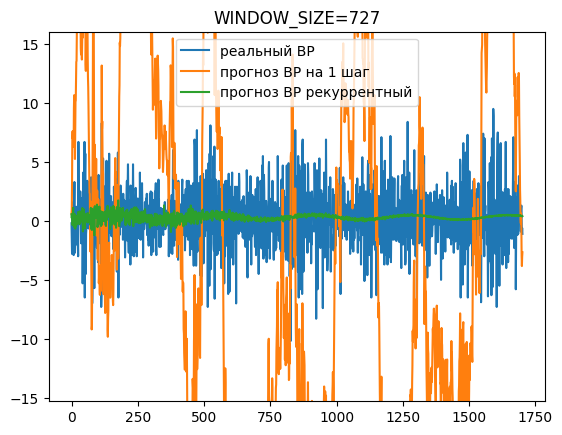

(16769, 977) (16769, 1)


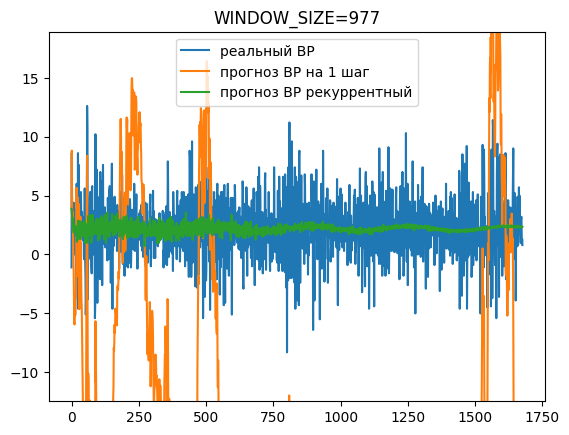

In [26]:
stats = []
series = []

# От 2 до 1001 с шагом 25. Пробуем 999/25 ~ 40 окон
# Не путать с эпохами !
windows = np.arange(2, 1001, 25)
for w in tqdm(windows):
    WINDOW_SIZE = w
    X = []
    def getWindows(x):
        X.append(x.values.copy())
        return 0

    df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
    X = np.array(X)
    y = X[:, WINDOW_SIZE:].copy()
    X = X[:, :WINDOW_SIZE].copy()
    # Размер X, y меняется каждую итерацию. Создаются новые "датасеты"
    # Не путать с эпохами !
    # на 10 эпохе: (9773, 227) (9773, 1). WINDOW_SIZE = 227
    # на 20 эпохе: (9523, 477) (9523, 1), WINDOW_SIZE = 477
    # на 30 эпохе: (9273, 727) (9273, 1), WINDOW_SIZE = 727
    # на 40 эпохе: (9023, 977) (9023, 1), WINDOW_SIZE = 977

    X_train = X[:X.shape[0]*9//10].copy()
    y_train = y[:y.shape[0]*9//10].copy()
    y_train -= X_train[:, -1:]
    X_train = np.diff(X_train)

    X_test = X[X.shape[0]*9//10:].copy()
    y_test = y[y.shape[0]*9//10:].copy()
    y_test -= X_test[:, -1:]
    X_test = np.diff(X_test)

    lr = LinearRegression().fit(X_train, y_train)

    tmp = []
    p = [lr.predict(X_test), recursive_predict(lr, X_test)]
    for preds in p:
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        tss = time_series_score(y_test, preds, X_test)
        tmp.extend([mae, r2*100, tss*100])
    stats.append(tmp)
    series.append(p)
    if (len(stats)%10)==0:
        print(X.shape, y.shape)
        plt.plot(np.cumsum(y_test), label='реальный ВР')
        plt.plot(np.cumsum(p[0]), label='прогноз ВР на 1 шаг')
        plt.plot(np.cumsum(p[1]), label='прогноз ВР рекуррентный')
        plt.title("WINDOW_SIZE=" + str(WINDOW_SIZE))
        plt.ylim(np.cumsum(y_test).min()*1.5, np.cumsum(y_test).max()*1.5)
        plt.legend(loc=0)
        plt.show()

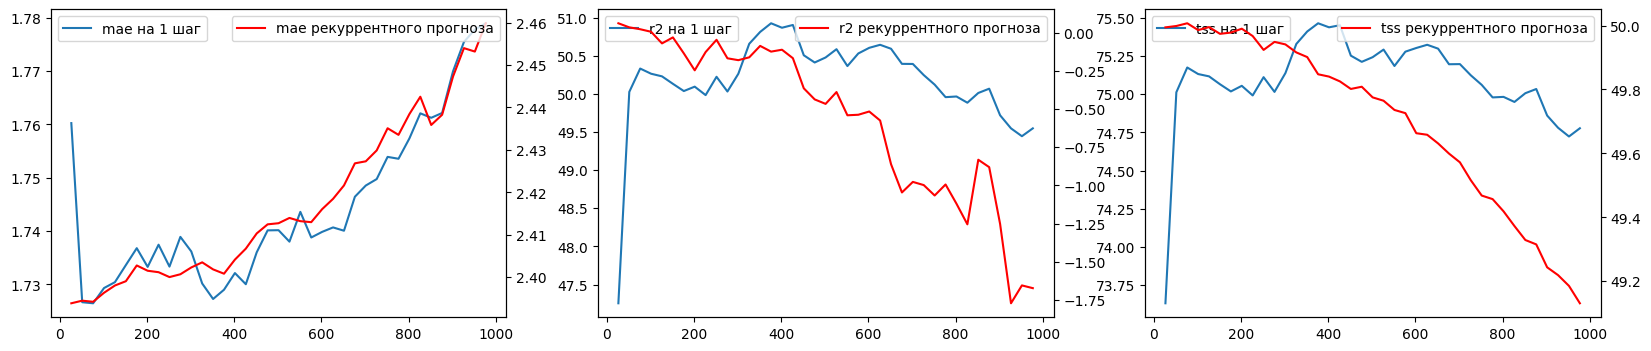

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# `stats` - это массив 6 x <Число эпох>. Сначала пишется тройка MAE, R2 score, TSS для прогноза на 1 шаг, затем - тройка MAE, R2 score, TSS для рекуррентного прогноза.

# Ось слева - синий график - ошибки MAE, R2, TSS для Linear Regression
ax[0].plot(windows[1:], np.array(stats)[1:,0], label='mae на 1 шаг')
ax[1].plot(windows[1:], np.array(stats)[1:,1], label='r2 на 1 шаг')
ax[2].plot(windows[1:], np.array(stats)[1:,2], label='tss на 1 шаг')

# Вторая ось справа - красный график - ошибки MAE, R2, TSS для RNN
ax_twinx = [ax_.twinx() for ax_ in ax]
ax_twinx[0].plot(windows[1:], np.array(stats)[1:,3], c='r', label='mae рекуррентного прогноза')
ax_twinx[1].plot(windows[1:], np.array(stats)[1:,4], c='r', label='r2 рекуррентного прогноза')
ax_twinx[2].plot(windows[1:], np.array(stats)[1:,5], c='r', label='tss рекуррентного прогноза')

for ax_ in ax:
    ax_.legend(loc='upper left')

for ax_ in ax_twinx:
    ax_.legend(loc='upper right')

Тут определяем, на каком размере окна MAE ошибка на 1 шаг была минимальна.

In [28]:
# Индекс эпохи, где ошибка MAE прогноза для 1 шага минимальна
idx = np.array(stats)[:, 0].argmin()
print(np.array(stats).shape)
print(np.array(stats)[:, 0])
print("мин. stats для MAE на 1 шаг =", stats[idx][0], "| его индекс idx =", idx)
# Все это нужно, чтобы извлечь самое удачное предссказание. flatten нужен только для того, чтобы [[<988 чисел>]] привести к [<988 чисел>]
print(series[idx][0].shape, series[idx][0].flatten().shape)

(40, 6)
[2.30942473 1.7602441  1.72664265 1.72644455 1.72930372 1.73040638
 1.73360764 1.73678211 1.73327302 1.73743424 1.73332607 1.73890093
 1.73616661 1.73015459 1.72725065 1.72898451 1.73211404 1.73001933
 1.73601063 1.74012208 1.74015688 1.73800642 1.74359315 1.73878565
 1.73984195 1.74067634 1.74005586 1.74643107 1.74853409 1.74974568
 1.75390876 1.75355503 1.75737526 1.76207946 1.76124094 1.7621482
 1.7699704  1.7754735  1.77779191 1.77897327]
мин. stats для MAE на 1 шаг = 1.7264445539240012 | его индекс idx = 3
(1767, 1) (1767,)


In [29]:
WINDOW_SIZE = windows[idx]
print('Оптимальный размер окна на синтетических данных:', WINDOW_SIZE)
print('MAE на 1 шаг =', stats[idx][0])
print('R2 на 1 шаг =', stats[idx][1])
print('TSS на 1 шаг =', stats[idx][2])
print('MAE рекуррентного прогноза =', stats[idx][3])
print('R2 рекуррентного прогноза =', stats[idx][4])
print('TSS рекуррентного прогноза =', stats[idx][5])

Оптимальный размер окна на синтетических данных: 77
MAE на 1 шага = 1.7264445539240012
R2 на 1 шага = 50.331557874329704
TSS на 1 шага = 75.17526512960421
MAE рекуррентного прогноза = 2.394181381489528
R2 рекуррентного прогноза = 0.021443173992197195
TSS рекуррентного прогноза = 50.00710123074439


### Результат оптимальной модели AR

In [35]:
# Снова воссоздаем выборку но уже с оптимальным WINDOW_SIZE
X = []
def getWindows(x):
    X.append(x.values.copy())
    return 0
df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)
X = np.array(X)
y = X[:, WINDOW_SIZE:].copy() # y (9800, 1)
X = X[:, :WINDOW_SIZE].copy() # X (9800, 200)
print(X.shape, y.shape) # где-то во время оьучения переменные переписываются, и теряется часть значений

X_train = X[:X.shape[0]*9//10].copy()
y_train = y[:y.shape[0]*9//10].copy()
y_train -= X_train[:, -1:]
X_train = np.diff(X_train)
print(X_train.shape, y_train.shape)

X_test = X[X.shape[0]*9//10:].copy()
y_test = y[y.shape[0]*9//10:].copy()
y_test -= X_test[:, -1:]
X_test = np.diff(X_test)
print(X_test.shape, y_test.shape)

(17669, 77) (17669, 1)
(15902, 76) (15902, 1)
(1767, 76) (1767, 1)


In [31]:
# Это последняя 0.1 часть от (почти) 9800 значений
X[X.shape[0]*9//10:].shape, X[X.shape[0]*9//10:, -1:].shape

((993, 77), (993, 1))

In [32]:
# preds_ar
# preds_naive
# отлючаются двоеточием
# И нахуя он СРЕДНЕЕ ОТ 1 СЧИТАЕТ? Еще и путает размерности
(X[X.shape[0]*9//10:, -1])[:5], X[X.shape[0]*9//10:, -1:].mean(axis=1)[:5]

(array([2.01245508, 2.23349826, 2.34316607, 2.3349628 , 2.92954596]),
 array([2.01245508, 2.23349826, 2.34316607, 2.3349628 , 2.92954596]))

Идеальный график слева - диагональ квадрата с углом наклона к горизонтальной оси 45 град.

AR RMSE: 2.285	Naive RMSE: 3.242


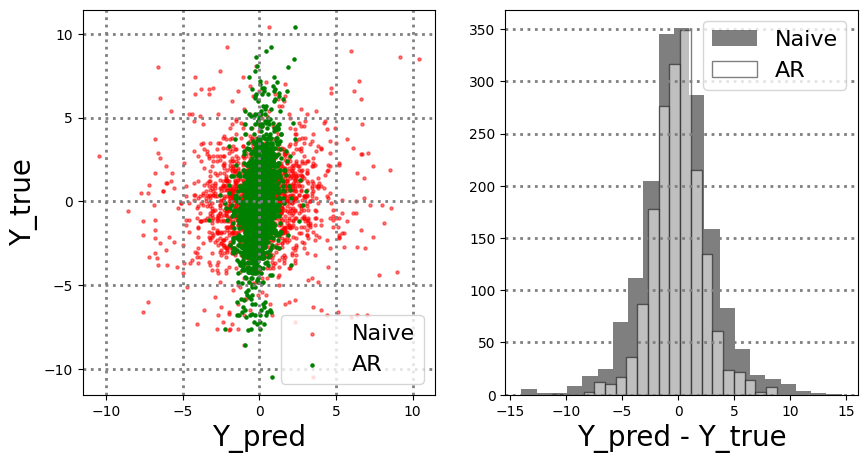

In [36]:
# Наложение предсказания для 1 шага с минимальной ошибкой MAE
preds_ar = X[X.shape[0]*9//10:, -1] + series[idx][0].flatten() # (980,) - значения для последнего окна
preds_naive = X[X.shape[0]*9//10:, -1:].mean(axis=1) # (980,) - значения для последнего окна
y_true = y[y.shape[0]*9//10:].flatten() # (980,)
# Ошибка предсказания
err_ar = y_true - preds_ar
# Отклонение игреков y_i от последнего в ряде X элемента X_(n-1)_i
err_naive = y_true - preds_naive

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    preds_naive,
    y_true,
    s=5,
    facecolor='red',
    alpha=0.5,
    label='Naive'
)
ax[0].scatter(
    preds_ar,
    y_true,
    s=5,
    facecolor='green',
    alpha=1,
    label='AR'
)
ax[1].hist(err_naive,
         bins=21,
         facecolor='k',
         alpha=0.5,
         label='Naive')
ax[1].hist(err_ar,
         bins=21,
         edgecolor='k',
         facecolor='w',
         alpha=0.5,
         label='AR')

ax[0].set_xlabel('Y_pred', fontsize=20)
ax[0].set_ylabel('Y_true', fontsize=20)
ax[1].set_xlabel('Y_pred - Y_true', fontsize=20)
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[0].grid(axis='both', linestyle=':', linewidth=2, color='gray')
ax[1].grid(axis='y', linestyle=':', linewidth=2, color='gray')

print('AR RMSE: %.3f\tNaive RMSE: %.3f'%(err_ar.std(), err_naive.std()))

## LSTM

Для LSTM добавил возможность выбрать датасет: синтетические данные или реальные.

В задании сказано:
> Обучить рекуррентную нейронную сеть на реальных данных погоды по варианту.

LSTM является RNN. Не сказано обучать авторегрессию.


### Гиперпараметры

In [336]:
# Архитектура

num_features = 1 # По умолчанию # Мы предсказываем одномерный выход
input_size = 1 # По умолчанию
# num_layers = 2 # По умолчанию
# hidden_size = 16 # По умолчанию
# bidirectional = True # По умолчанию
dropout_rate = 0.2 # По умолчанию

# П.4 Одна однонаправленна ячейку LSTM, 3 размерности hidden size 
hidden_size = 8
num_layers = 1
bidirectional = False


In [337]:
# Параметры обучения

# Если True, датасет будет содержать синтетические данные из `df`
# Если False - реальные данные из `df_real`
IS_SYNTETHIC_DATASET = True
# IS_SYNTETHIC_DATASET = False

# EPOCHS = 40 # По умолчанию
# batch_size = 512 # По умолчанию
# learning_rate = 0.01 # По умолчанию

EPOCHS = 40
batch_size = 512
learning_rate = 0.01

In [338]:
MODEL_NAME = datetime.now().strftime("%d.%m-%H:%M:%S")  # даты будут -3 часа, т.к. часовой пояс на сервере Kaggle - UTC +0
os.environ["MODEL_NAME"] = MODEL_NAME # буду использовать для названия zip-архива в unix-команде

def print_model_params():
  print({
    'ModelName': MODEL_NAME,
    'EPOCHS': EPOCHS,
    "BS": batch_size,
    'LR': learning_rate,
    "HS": hidden_size,
})

print_model_params()

{'ModelName': '13.05-14:00:02', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 8}


### Модель

In [321]:
# Это многослойная двунаправленная LSTM для регрессии
class LSTM(nn.Module):

    def __init__(self, num_features, input_size, hidden_size, num_layers,
                 bidirectional=True, p=0.4,
                 # добавил параметр - логировать forward или нет
                 log=False):
        super(LSTM, self).__init__()

        self.num_features = num_features
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.log = log

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(p)

        # В задаче РЕСГРЕССИИ нужен полносвязный (fc) слой
        self.fc = nn.Linear(2*hidden_size if bidirectional else hidden_size, num_features)


    def init_hidden(self, dim, device):
        h_0 = torch.autograd.Variable(
            torch.zeros(
                2*self.num_layers if self.bidirectional else self.num_layers,
                dim,
                self.hidden_size,
                device=device
            )
        )

        c_0 = torch.autograd.Variable(
            torch.zeros(
                2*self.num_layers if self.bidirectional else self.num_layers,
                dim,
                self.hidden_size,
                device=device
            )
        )
        return (h_0, c_0)


    def forward(self, x, hidden=None):
        if self.log:
          print('x', x.shape)
          # torch.Size([batch_size, sequence_length])

        if hidden is None:
            hidden = self.init_hidden(x.size(0), x.device)

        # Тут преобразовали размерность x: `x.view(x.size(0), x.size(1), 1)`.
        # По требованию библиотеки нужно привести к виду (batch_size, sequence_length, input_size)
        lstm_out, hidden = self.lstm(x.view(x.size(0), x.size(1), 1), hidden)

        if self.log:
          print('lstm_out.shape 1', lstm_out.shape)
          # torch.Size([batch_size, sequence_length, 32]) для Bidirectional, torch.Size([batch_size, sequence_length, 16]) для обычной

        # Оставляем только последний элемент по второму измерению
        # Библиотечный nn.LSTM дает прогноз векторов размерности hidden_size на sequence_length элементов, но из них нам нужен только 1 - следующий
        lstm_out = lstm_out[:, -1, :]

        if self.log:
          print('lstm_out.shape 2', lstm_out.shape)
          # lstm_out.shape torch.Size([batch_size, 32]) для Bidirectional, torch.Size([batch_size, 16]) для обычной
          print('hidden len', len(hidden))
          # 2 - для Bidirectional, 1 - для обычной
          print('hidden shapes', [h.shape for h in hidden])
          # hidden shapes [torch.Size([4, batch_size, hidden_size]), torch.Size([4, batch_size, hidden_size])] - массив из 2-х для Bidirectional

        h_out = lstm_out.view(x.size(0), -1)

        out = self.fc(self.dropout(h_out))
        if self.log:
          print('out.shape', out.shape)
        # out.shape torch.Size([batch_size, 1])

        return out, hidden

In [339]:
model = LSTM(
    num_features,
    input_size,
    hidden_size,
    num_layers,
    bidirectional,
    dropout_rate
).to(device)

criterion = torch.nn.MSELoss()    # среднекврадратическое отклонение
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# добавляем постепенное уменьшение шага обучения каждые 15 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

#### Изучаем архитектуру

In [340]:
print_model_params()
# Объяснение тут
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
for name, weight in model.named_parameters():
    print(name, weight.shape)

{'ModelName': '13.05-14:00:02', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 8}
lstm.weight_ih_l0 torch.Size([32, 1])
lstm.weight_hh_l0 torch.Size([32, 8])
lstm.bias_ih_l0 torch.Size([32])
lstm.bias_hh_l0 torch.Size([32])
fc.weight torch.Size([1, 8])
fc.bias torch.Size([1])


In [341]:
# %%script echo skipping

print_model_params()

model_with_log = LSTM(
    num_features,
    input_size,
    hidden_size,
    num_layers,
    bidirectional,
    dropout_rate,
    True,
).to(device)

# Взял размерность как в тренировочной выборке `tensor_X_test` ниже:
# batch_size (N) 925
# sequence_length (L) 749
# Тут я передаю один первый пример из тестовой выборки, batch_size = 1
# test_predict, hidden_predict = model_with_log(tensor_X_test.to(device)[0])
test_predict, hidden_predict = model_with_log(torch.rand(925, 749).to(device))

# соответствует тому, что возвращает (class LSTM).forward()
print('test_predict.shape', test_predict.shape)
print('hidden shapes', [h.shape for h in hidden_predict])

{'ModelName': '13.05-14:00:02', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 8}
x torch.Size([925, 749])
lstm_out.shape 1 torch.Size([925, 749, 8])
lstm_out.shape 2 torch.Size([925, 8])
hidden len 2
hidden shapes [torch.Size([1, 925, 8]), torch.Size([1, 925, 8])]
out.shape torch.Size([925, 1])
test_predict.shape torch.Size([925, 1])
hidden shapes [torch.Size([1, 925, 8]), torch.Size([1, 925, 8])]


### Датасет LSTM

Для синтетической выборки заново собирается датасет. Но уже с размером окна `WINDOW_SIZE = 750`.

In [342]:
WINDOW_SIZE = 750

X = []
def getWindows(x):
    X.append(x.values.copy())
    return 0

y = None
X_train = None
y_train = None
X_test = None
y_test = None

if (IS_SYNTETHIC_DATASET):
  # синтетические данные
  df.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)

  X = np.array(X)
  y = X[:, WINDOW_SIZE:].copy()
  X = X[:, :WINDOW_SIZE].copy()
  print(X.shape, y.shape) # 9250 окон размером 750 каждое. Окна отличаются друг от друга сдвигом на 1 вправо. 1 окно - 1 батч

  X_train = X[:X.shape[0]*9//10].copy()
  y_train = y[:y.shape[0]*9//10].copy()
  y_train -= X_train[:, -1:]
  X_train = np.diff(X_train)
  print(X_train.shape, y_train.shape)

  X_test = X[X.shape[0]*9//10:].copy()
  y_test = y[y.shape[0]*9//10:].copy()
  y_test -= X_test[:, -1:]
  X_test = np.diff(X_test)
  print(X_test.shape, y_test.shape)
else:
  # реальные данные

  # Важно отличие df_real от df
  # В df_real делается .diff().dropna()
  #
  # В pandas.dataframe.diff() появляется много NA
  # В numpy.diff() NA удаляются, и выборка смещается
  df_real.rolling(WINDOW_SIZE+1).apply(getWindows, raw=False)

  X = np.array(X)
  y = X[:, WINDOW_SIZE:].copy()
  X = X[:, :WINDOW_SIZE].copy()
  print(X.shape, y.shape) # 9250 окон размером 750 каждое. Окна отличаются друг от друга сдвигом на 1 вправо. 1 окно - 1 батч

  X_train = X[:X.shape[0]*9//10].copy()
  y_train = y[:y.shape[0]*9//10].copy()
  print(X_train.shape, y_train.shape)

  X_test = X[X.shape[0]*9//10:].copy()
  y_test = y[y.shape[0]*9//10:].copy()
  print(X_test.shape, y_test.shape)

(9250, 750) (9250, 1)
(8325, 749) (8325, 1)
(925, 749) (925, 1)


In [326]:
# Проверка, что данные ОК. Должна быть синусоида длиной WINDOW_SIZE / длину цикла
# plt.plot(np.arange(0, WINDOW_SIZE), np.cumsum(X_train[0]))

In [343]:
#MAX_VAL = np.abs(y_train).max()
tensor_X_train = torch.autograd.Variable(torch.Tensor(X_train))
tensor_y_train = torch.autograd.Variable(torch.Tensor(y_train))

tensor_X_test = torch.autograd.Variable(torch.Tensor(X_test))
tensor_y_test = torch.autograd.Variable(torch.Tensor(y_test))

dataset = TensorDataset(tensor_X_train, tensor_y_train)

dataset_test = TensorDataset(tensor_X_test, tensor_y_test)

dataloader = {}
dataloader['train'] = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader['test'] = DataLoader(dataset_test, batch_size=128, shuffle=False)
del dataset, dataset_test

In [328]:
# Демонстрация скользящего окна.
# 5 первых значений "окна" с индексом 0 и 5 первых значений "окна" с индексом 1
tensor_X_test[0][:5], tensor_X_test[1][:5]

(tensor([ 0.1272, -0.0523, -0.4723,  0.5493, -0.4813]),
 tensor([-0.0523, -0.4723,  0.5493, -0.4813,  0.0429]))

### Обучение


Эпоха: 40
Текущее значение функции потерь: MSE=6,53e-02, r2=44,34%.
Лучшее значение функции потерь: MSE=6,53e-02, r2=44,39% на 29 эпохе.


  0%|          | 0/680 [00:00<?, ?it/s]

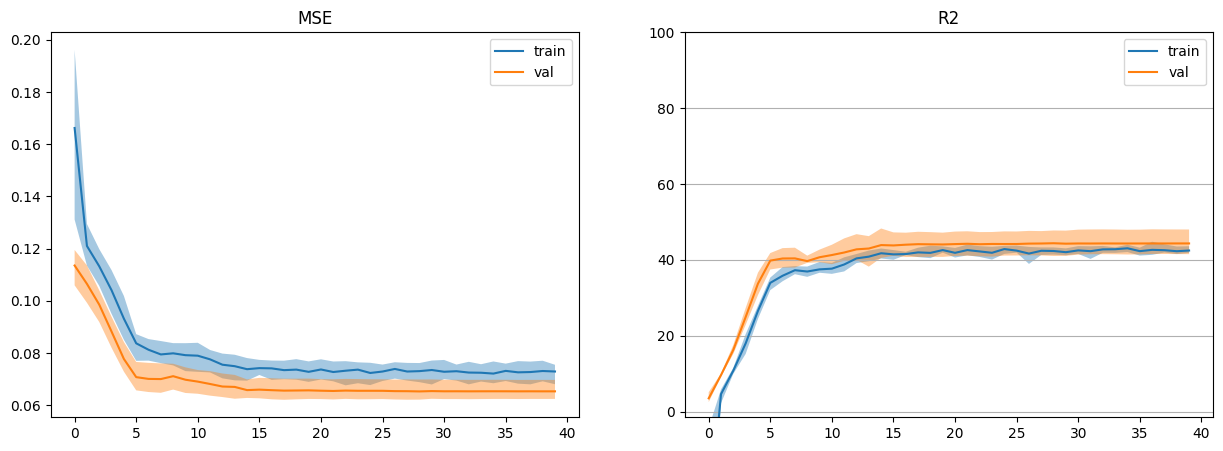


Обучение закончено за 34.01 секунд
{'ModelName': '13.05-14:00:02', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 8}

Лучшее - 29 эпоха:
MSE: train=7,31e-02, test=6,53e-02
R2: train=42,35, test=44,39


In [344]:
REDRAW_EVERY = 1
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_loss = np.inf
best_loss_idx = -1
best_loss_r2 = -1

checkpoint_path = 'ts.pth'
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    model.train()
    hidden = None
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = [xx.to(device) for xx in batch]

        print

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        if hidden is not None and inputs.shape[0] != hidden[0].shape[1]:
            print(inputs.shape[0], hidden[0].shape[1])
            hidden = None
        outputs, hidden = model(inputs, hidden)
        hidden = tuple([e.data for e in hidden])
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        # обрезка градиентов
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # обновление параметров модели
        optimizer.step()

        # для подсчёта статистик
        accuracy = 100*r2_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
        tmp.append((loss.item(), accuracy))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    model.eval()
    hidden = None
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)
            if hidden is not None and inputs.shape[0] != hidden[0].shape[1]:
                print(inputs.shape[0], hidden[0].shape[1])
                hidden = None
            outputs, hidden = model(inputs, hidden)
            hidden = tuple([e.data for e in hidden])
            loss = criterion(outputs, labels)
            accuracy = 100*r2_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            tmp.append((loss.item(), accuracy))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    loss = losses_val[-1][0][0]
    r2 = losses_val[-1][0][1]
    if loss < best_loss:
        best_loss = loss
        best_loss_idx = epoch
        best_loss_r2 = r2
        torch.save(model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('\nЭпоха: %s' % (epoch+1))
    print('Текущее значение функции потерь: MSE=%s, r2=%s%%.' % ('{:.2e}'.format(loss).replace('.', ','), "{:.2f}".format(r2).replace('.', ',')))
    print('Лучшее значение функции потерь: MSE=%s, r2=%s%% на %d эпохе.' % ('{:.2e}'.format(best_loss).replace('.', ','), "{:.2f}".format(best_loss_r2).replace('.', ','), best_loss_idx+1))
    # print('Эпоха: %s\n'
    #       'Лучшее значение функции потерь: %s\n'
    #       'Текущее значение функции потерь: %s' % (epoch+1, best_loss, loss))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['MSE', 'R2']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
model.load_state_dict(torch.load(checkpoint_path))

print('\nОбучение закончено за %s секунд' % "{:.2f}".format(passed))
print_model_params()
print('\nЛучшее -', best_loss_idx+1, 'эпоха:')
print(('MSE: train=%s, test=%s' % ('{:.2e}'.format(losses[best_loss_idx][0][0]), '{:.2e}'.format(losses_val[best_loss_idx][0][0]))).replace('.', ','))
print('R2: train=%s, test=%s' % ("{:.2f}".format(losses[best_loss_idx][0][1]).replace('.', ','), "{:.2f}".format(losses_val[best_loss_idx][0][1]).replace('.', ',')))

### Оценка качества модели

{'ModelName': '13.05-13:52:00', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 32}


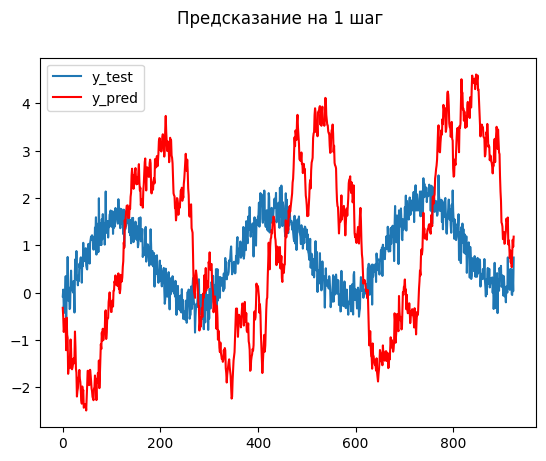

In [330]:
print_model_params()

model.eval()
test_predict, _ = model(tensor_X_test.to(device))

data_predict = test_predict.data.cpu().numpy()#*MAX_VAL
dataY_plot = tensor_y_test.data.cpu().numpy()#*MAX_VAL

plt.plot(np.cumsum(dataY_plot), label='y_test')
plt.plot(np.cumsum(data_predict), color='r', label='y_pred')
# plt.suptitle('Time-Series Prediction')
plt.suptitle('Предсказание на 1 шаг')

plt.legend()
plt.show()

Идеальный график слева - диагональ квадрата с углом наклона к горизонтальной оси 45 град.

{'ModelName': '13.05-13:52:00', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 32}
LSTM RMSE: 0.254	Naive RMSE: 0.342


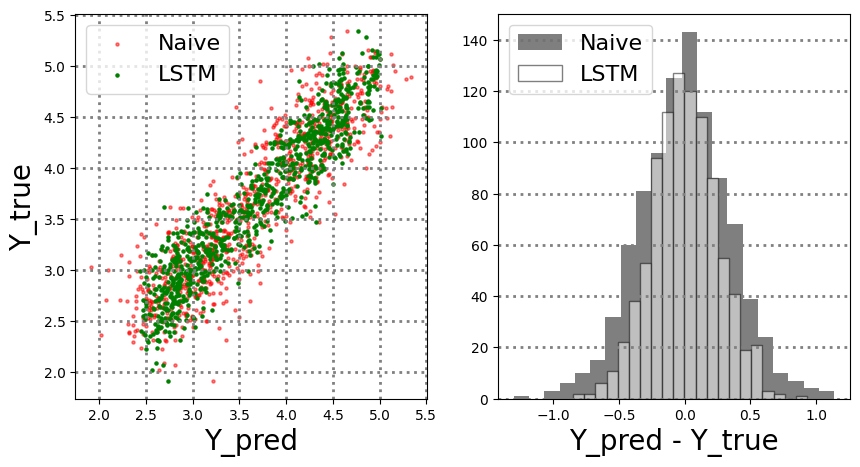

In [331]:
preds_ar = X[X.shape[0]*9//10:, -1] + data_predict.flatten()
preds_naive = X[X.shape[0]*9//10:, -1:].mean(axis=1)
y_true = y[y.shape[0]*9//10:].flatten()
err_ar = y_true - preds_ar
err_naive = y_true - preds_naive

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(
    preds_naive,
    y_true,
    s=5,
    facecolor='red',
    alpha=0.5,
    label='Naive'
)
ax[0].scatter(
    preds_ar,
    y_true,
    s=5,
    facecolor='green',
    alpha=1,
    label='LSTM'
)
ax[1].hist(err_naive,
         bins=21,
         facecolor='k',
         alpha=0.5,
         label='Naive')
ax[1].hist(err_ar,
         bins=21,
         edgecolor='k',
         facecolor='w',
         alpha=0.5,
         label='LSTM')

ax[0].set_xlabel('Y_pred', fontsize=20)
ax[0].set_ylabel('Y_true', fontsize=20)
ax[1].set_xlabel('Y_pred - Y_true', fontsize=20)
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[0].grid(axis='both', linestyle=':', linewidth=2, color='gray')
ax[1].grid(axis='y', linestyle=':', linewidth=2, color='gray')

print_model_params()
print('LSTM RMSE: %.3f\tNaive RMSE: %.3f'%(err_ar.std(), err_naive.std()))
# print('Naive RMSE: %.3f'%(err_naive.std()))

{'ModelName': '13.05-13:52:00', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 32}


  0%|          | 0/925 [00:00<?, ?it/s]

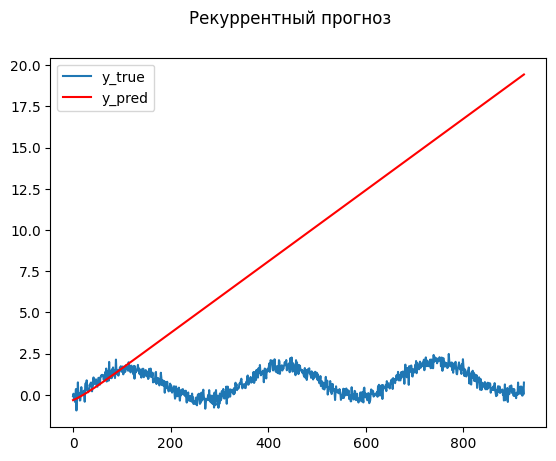

In [332]:
# Рекуррентный прогноз
print_model_params()

model.eval()
last_value = tensor_X_test[0].clone()
preds = []
hidden = None
with torch.no_grad():
    for i in tqdm(range(y_test.shape[0])):
        output, hidden = model(last_value.view(1, last_value.size(-1)).to(device), hidden)
        hidden = tuple([e.data for e in hidden])
        preds.append(output.detach().cpu().item())
        last_value[:-1] = last_value[1:].clone()
        last_value[-1:] = preds[-1]
preds = np.array(preds)# * MAX_VAL
plt.plot(np.cumsum(y_test), label='y_true')
plt.plot(np.cumsum(preds), label='y_pred', color='r')
plt.suptitle('Рекуррентный прогноз')
plt.legend()

Зависимость качества предсказания от количества $j$ точек $X_{i,j}$, поданных на вход

In [333]:
print_model_params()

print('='*50)
print('#', 'Тип', 'Кол-во точек', 'R2, %', 'TSS, %', sep='\t')
for p, label in zip([data_predict, preds], ['one-step', 'recursive']):
    for front in [2, 3, 5, 10, 50, -1]:
        print('#',
              label,
              front,
              '%.2f'%(r2_score(y_test[:front],
                               p[:front])*100),
              '%.2f'%(time_series_score(y_test[:front],
                                        p[:front],
                                        X_test[:front],
                                        previous_cnt=3)*100),
              sep='\t')
    print('='*50)

{'ModelName': '13.05-13:52:00', 'EPOCHS': 40, 'BS': 512, 'LR': 0.01, 'HS': 32}
#	Тип	Кол-во точек	R2, %	TSS, %
#	one-step	2	-652.71	-367.90
#	one-step	3	-35.09	45.71
#	one-step	5	-20.84	38.16
#	one-step	10	59.06	61.38
#	one-step	50	46.57	52.60
#	one-step	-1	45.09	50.56
#	recursive	2	-212.24	-283.97
#	recursive	3	-64.20	38.47
#	recursive	5	-50.41	23.85
#	recursive	10	-1.51	2.99
#	recursive	50	-0.55	10.21
#	recursive	-1	-0.44	9.53
